# Hausaufgaben Bayer

Your task is to check the feasability of an automated sentiment analysis tool for EPARs, ultimately helping the regulatory colleagues to quickly
identify (sub-) optimal clinical trial properties and learn from competitor
activities.

In [1]:
!pip install pandas
!pip install xlrd
!pip install seaborn
!pip install spacy
!pip install nltk
!pip install PyPDF2
!pip install sklearn

In [2]:
!python -m spacy download en 

symbolic link created for C:\ProgramData\Anaconda3\envs\bayer_app\lib\site-packages\spacy\data\en <<===>> C:\ProgramData\Anaconda3\envs\bayer_app\lib\site-packages\en_core_web_sm
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[+] Linking successful
C:\ProgramData\Anaconda3\envs\bayer_app\lib\site-packages\en_core_web_sm -->
C:\ProgramData\Anaconda3\envs\bayer_app\lib\site-packages\spacy\data\en
You can now load the model via spacy.load('en')


In [3]:
import pandas as pd

In [4]:
# Constants
color_bayer_dark_blue = '#333399'
color_bayer_light_blue = '#01BEFF'
color_bayer_green = '#56D500'

In [5]:
# load data
df = pd.read_excel('data/sentences_with_sentiment_final.xls')

In [6]:
df.head()

,ID,Sentence,Positive,Negative,Neutral
0,1,The results in 2nd line treatment show an ORR ...,1,0,0
1,2,The long duration of response and high durable...,1,0,0
2,3,The median OS time in the updated results exce...,0,0,1
3,4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0
4,5,"The data provided in 1st line, although prelim...",1,0,0


## Missing Values

In [7]:
# check for missing values --> no missing values
df.isnull().sum()

ID          0
Sentence    0
Positive    0
Negative    0
Neutral     0
dtype: int64

## Feature Engineering

In [8]:
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [9]:
# add feature that describes sentiment as one number
df['Sentiment'] = df.apply(lambda x: 0 if x['Negative'] else 1 if x['Neutral'] else 2, axis=1)
df['Sentiment_Text'] = df.apply(lambda x: 'Negativ' if x['Negative'] else 'Neutral' if x['Neutral'] else 'Positiv', axis=1)

In [10]:
# check if sentence has two sentiments --> no
df[['Positive', 'Negative', 'Neutral']].iloc[0].sum()

1

In [11]:
df['Sentiment'].value_counts()

2    160
1     70
0     36
Name: Sentiment, dtype: int64

In [12]:
# construct df with two sentiments by merging neutral and negative (the ones with the fewest examples)
df['Sentiment_Easy'] = df['Sentiment'].apply(lambda x: 1 if x == 2 else 0)
df['Sentiment_Easy_Text'] = df['Sentiment_Easy'].apply(lambda x: 'Positiv' if x == 1 else 'Other')

In [13]:
df.head(5)

,ID,Sentence,Positive,Negative,Neutral,Sentiment,Sentiment_Text,Sentiment_Easy,Sentiment_Easy_Text
0,1,The results in 2nd line treatment show an ORR ...,1,0,0,2,Positiv,1,Positiv
1,2,The long duration of response and high durable...,1,0,0,2,Positiv,1,Positiv
2,3,The median OS time in the updated results exce...,0,0,1,1,Neutral,0,Other
3,4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0,2,Positiv,1,Positiv
4,5,"The data provided in 1st line, although prelim...",1,0,0,2,Positiv,1,Positiv


In [14]:
# check if there are only two categories after merging neutral and negative
df['Sentiment_Easy'].value_counts()

1    160
0    106
Name: Sentiment_Easy, dtype: int64

In [15]:
# remove punctiation, stop words and lemmatisation
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()

def clean_sentence(sentence):
    # convert sentence into tokens (words)
    sentence = nlp(sentence)
    # Lemmatizing  
    sentence = [word.lemma_.lower().strip() for word in sentence]
   
    # remove stop words
    return [word for word in sentence if word not in stop_words and word not in string.punctuation]
    

df['Sentence_Cleaned'] = df['Sentence'].apply(lambda x: " ".join(clean_sentence(x)))

In [16]:
df.head(1)

,ID,Sentence,Positive,Negative,Neutral,Sentiment,Sentiment_Text,Sentiment_Easy,Sentiment_Easy_Text,Sentence_Cleaned
0,1,The results in 2nd line treatment show an ORR ...,1,0,0,2,Positiv,1,Positiv,result 2nd line treatment orr 33 patient durab...


## Data Exploration

In [17]:
import nltk
import re
import PyPDF2
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from nltk.collocations import BigramCollocationFinder
from nltk import word_tokenize
from os import listdir
from os.path import isfile, join

In [18]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,266.0,133.500000,76.931788,1.0,67.25,133.5,199.75,266.0
Positive,266.0,0.601504,0.490511,0.0,0.00,1.0,1.00,1.0
Negative,266.0,0.135338,0.342729,0.0,0.00,0.0,0.00,1.0
Neutral,266.0,0.263158,0.441177,0.0,0.00,0.0,1.00,1.0
Sentiment,266.0,1.466165,0.722144,0.0,1.00,2.0,2.00,2.0
Sentiment_Easy,266.0,0.601504,0.490511,0.0,0.00,1.0,1.00,1.0


In [19]:
# How many examples do we have per vote
df[['Positive', 'Negative', 'Neutral']].value_counts()

Positive  Negative  Neutral
1         0         0          160
0         0         1           70
          1         0           36
dtype: int64

In [20]:
bayer_colors = [color_bayer_green, color_bayer_dark_blue, color_bayer_light_blue]
customPalette = sns.set_palette(sns.color_palette(bayer_colors))

[Text(0.5, 0, 'Sentiment'),
 Text(0, 0.5, 'Anzahl'),
 Text(0.5, 1.0, 'Anzahl Beispiele per Sentiment')]

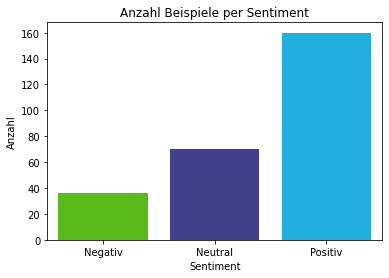

In [21]:
ax = sns.countplot(x='Sentiment_Text', data=df, palette=customPalette, order=['Negativ', 'Neutral', 'Positiv'] )
ax.set(xlabel="Sentiment", ylabel = "Anzahl", title="Anzahl Beispiele per Sentiment")

In [22]:
# check if there is more than one sentiment assigned to same sentence --> there is not
df.apply(lambda x: False if sum([x['Negative'], x['Neutral'], x['Positive']]) > 1 else True, axis=1).value_counts()

True    266
dtype: int64

### Finde relevante Sätze

In [23]:
# find most common words with frequency
sentences_list = df['Sentence_Cleaned']
sentences = " ".join(sentences_list)
doc = nlp(sentences)
words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
word_freq = Counter(words)
most_common_words_count = word_freq.most_common(25)

for i in most_common_words_count:
    print(f'{i[0]}: {i[1]}')

study: 102
safety: 81
datum: 65
patient: 52
efficacy: 47
treatment: 40
clinical: 38
product: 38
consider: 35
profile: 31
support: 30
ct: 30
p10: 30
dose: 27
provide: 25
result: 23
subject: 23
compare: 22
mg: 22
week: 22
additional: 21
combination: 21
difference: 20
effect: 19
term: 19


In [24]:
# extract most common words
most_common_words = [' ' + x[0] for x in most_common_words_count]

In [25]:
# check how many common words a sentence has
def count_common_words(sentences_list, most_common_words, start = 0, up_to = 5):
    sentences_with_multiple_common_words = []
    sentences_word_coverage = {}
    for num in range(start,up_to):
        for sent in sentences_list:
            word_matches = [c_w for c_w in most_common_words if c_w in sent]
            if  len(word_matches) > num:
                sentences_with_multiple_common_words.append(sent)

        print(f'{len(sentences_with_multiple_common_words)* 100 / len(sentences_list):.2f}% der Sätze beinhalten {str(num+1)} der Top 25 Wörter')
        sentences_word_coverage[num+1] = len(sentences_with_multiple_common_words)* 100 / len(sentences_list)
        sentences_with_multiple_common_words.clear()
    return sentences_word_coverage

In [26]:
sentences_word_coverage = count_common_words(sentences_list, most_common_words)

91.35% der Sätze beinhalten 1 der Top 25 Wörter
72.93% der Sätze beinhalten 2 der Top 25 Wörter
49.25% der Sätze beinhalten 3 der Top 25 Wörter
30.83% der Sätze beinhalten 4 der Top 25 Wörter
19.92% der Sätze beinhalten 5 der Top 25 Wörter


No handles with labels found to put in legend.


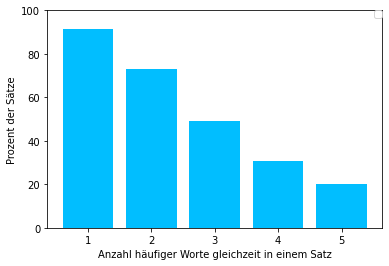

In [27]:
series = pd.Series(sentences_word_coverage) 
keys = sentences_word_coverage.keys()
vals = sentences_word_coverage.values()

plt.bar(keys, vals, color=color_bayer_light_blue)

plt.ylabel ('Prozent der Sätze')
plt.xlabel ('Anzahl häufiger Worte gleichzeit in einem Satz')
plt.xticks(list(keys))
plt.ylim(0,100)
#plt.title('Wieviel häufige Worte kommen gleichzeitig in relevanten Sätzen vor')
plt.legend (bbox_to_anchor=(1, 1), loc="upper right", borderaxespad=0.)

plt.show()

In [28]:
# ngram frequencies to detect relevant sentences --> might be good indicator but more reseach into 
# relevant groups required (e.g. group "of the" is just ctoo common everywhere)
sentences_list = df['Sentence'].tolist()
sentences = " ".join(sentences_list)
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(word_tokenize(sentences))
for k,v in sorted(finder.ngram_fd.items(), key=lambda item: item[1], reverse=True):
    print(k,v)
    if v == 10:
        break

('of', 'the') 68
('.', 'The') 67
('in', 'the') 51
(',', 'the') 37
('safety', 'profile') 24
('to', 'the') 23
('has', 'been') 22
('with', 'the') 21
('profile', 'of') 21
('patients', 'with') 20
('on', 'the') 19
('for', 'the') 19
('the', 'safety') 19
('in', 'patients') 16
('support', 'the') 15
('efficacy', 'of') 14
(')', '.') 14
('compared', 'to') 13
('from', 'the') 13
('safety', 'data') 13
('the', 'reference') 13
('to', 'be') 12
('.', 'In') 12
(',', 'and') 11
('have', 'been') 11
('clinical', 'data') 11
('the', 'FRC') 11
('by', 'the') 10


#### Extract important sentences from EPARs
1. Extract only Discussion section
2. Extract all sentences
3. check how many sentences contain common words from provided important sentences

In [29]:
def extract_relevant_sentences(filename, most_common_words, start, num_top_hits):
    pages = []
    with open(filename,'rb') as pdf_file:
        read_pdf = PyPDF2.PdfFileReader(pdf_file)
        number_of_pages = read_pdf.getNumPages()
        for page_number in range(number_of_pages):   # use xrange in Py2
            page = read_pdf.getPage(page_number)
            pages.append(page.extractText())
    
    text = " ".join(pages)
    text = text.lower()
    text = text.replace('\n', ' ')
    
    headline_indexes = [m.end(0) for m in re.finditer('2 scientific discussion| 2. scientific discussion', text)]
 
    # 1. Extract relevant section
    if len(headline_indexes) > 1:
        text = text[headline_indexes[1]:]
        
    # 2. extract sentences
    doc = nlp(text)
    
    # 3. Count sentences with common words
    count_common_words([x.text for x in doc.sents], most_common_words, start, num_top_hits)

In [30]:
# Print word frequency stats for EPARs
epar_files = [f for f in listdir('EPARs') if isfile(join('EPARs', f))]
for index, file in enumerate(epar_files):
    print(f'\n{index}.{file}')
    extract_relevant_sentences('EPARs/' + file, most_common_words,0, 5)


0.1. gilenya-epar-public-assessment-report_en.pdf
36.26% der Sätze beinhalten 1 der Top 25 Wörter
16.02% der Sätze beinhalten 2 der Top 25 Wörter
6.84% der Sätze beinhalten 3 der Top 25 Wörter
2.22% der Sätze beinhalten 4 der Top 25 Wörter
0.91% der Sätze beinhalten 5 der Top 25 Wörter

1.1. taltz-epar-public-assessment-report_en.pdf
37.62% der Sätze beinhalten 1 der Top 25 Wörter
14.77% der Sätze beinhalten 2 der Top 25 Wörter
5.82% der Sätze beinhalten 3 der Top 25 Wörter
2.17% der Sätze beinhalten 4 der Top 25 Wörter
0.67% der Sätze beinhalten 5 der Top 25 Wörter

2.1. temozolomide-teva-epar-public-assessment-report_en.pdf
44.72% der Sätze beinhalten 1 der Top 25 Wörter
21.34% der Sätze beinhalten 2 der Top 25 Wörter
8.13% der Sätze beinhalten 3 der Top 25 Wörter
2.03% der Sätze beinhalten 4 der Top 25 Wörter
0.41% der Sätze beinhalten 5 der Top 25 Wörter

3.1. vargatef-epar-public-assessment-report_en.pdf
33.18% der Sätze beinhalten 1 der Top 25 Wörter
13.80% der Sätze beinhalten 

## Train + Test Models

As there are few examples to train and test on and becasue of the imbalanced data, each analysis is done twice. The 1st analysis predicts all three sentiments (negative, neutral and positive)
and the 2nd analysis predicts two sentiments namele positive and other (i.e. merge of neutral and negative)
### Strategies
1. Establish baseline with simple model (supervised learning)
  * Random Forest classifier
  * Input ist Satz als tfidf 
2. As we have little data, an unsupervised learning method using the pretrained vader model is used. Thus no training required. 
  * Python Vader: Model for sentiment analysis
    * Vader has dictionary to translate lexikal properties to emotions
    * The sentiment of a sentence is the sum of sentiments of the words in the sentence
    * Vader is trained with social media data. This is not ideal. Lack of data and time contrainst make this a good second approach to analyse sentiments

In [31]:
import operator
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report,confusion_matrix

#### Strategy 1
Supervised Learning using RandomForest to establish baseline perfomance. TF-IDF is used to convert text to numbers.

In [32]:
# Random Forest:
text_clf_dr = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', RandomForestClassifier()),
])

##### Predict three sentiments

In [33]:
df.head(1)

,ID,Sentence,Positive,Negative,Neutral,Sentiment,Sentiment_Text,Sentiment_Easy,Sentiment_Easy_Text,Sentence_Cleaned
0,1,The results in 2nd line treatment show an ORR ...,1,0,0,2,Positiv,1,Positiv,result 2nd line treatment orr 33 patient durab...


In [34]:
X = df['Sentence_Cleaned']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [35]:
text_clf_dr.fit(X_train, y_train)
predictions = text_clf_dr.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[ 5  1  8]
 [ 0  5 19]
 [ 0  2 48]]
              precision    recall  f1-score   support

           0       1.00      0.36      0.53        14
           1       0.62      0.21      0.31        24
           2       0.64      0.96      0.77        50

    accuracy                           0.66        88
   macro avg       0.76      0.51      0.54        88
weighted avg       0.69      0.66      0.61        88



The results are not good. Easpecially recall for sentiments 0 and 1 (negative and neutral) could be improved

##### Predict two sentiments

In [36]:
X = df['Sentence_Cleaned']
y = df['Sentiment_Easy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [37]:
text_clf_dr.fit(X_train, y_train)
predictions = text_clf_dr.predict(X_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.74      0.37      0.49        38
           1       0.65      0.90      0.76        50

    accuracy                           0.67        88
   macro avg       0.69      0.63      0.62        88
weighted avg       0.69      0.67      0.64        88

[[14 24]
 [ 5 45]]


Results are a bit better but still improveable.

#### Strategy 2: Unsupervised learning with pretrained model

##### Predict three sentiments

In [38]:
sentiment_analyzer = SentimentIntensityAnalyzer()

In [39]:
### 3 Sätze zum raten
guess_sentiment_1 = df.iloc[15]['Sentence'] # 'No major concerns have been identified in the updated analysis'
guess_sentiment_2 = df.iloc[39]['Sentence'] # 'The applicant provided six pivotal studies to support this application.'
guess_sentiment_3 = df.iloc[35]['Sentence'] # 'Therefore, the CHMP endorsed the proposed dose of 300 mg every other week (Q2W) with a loading dose of 600 mg on day 1.'

print(f'{guess_sentiment_1:{130}} {sentiment_analyzer.polarity_scores(guess_sentiment_1)}') # korrekt: positiv
print(f'{guess_sentiment_2:{130}} {sentiment_analyzer.polarity_scores(guess_sentiment_2)}') # korrekt: neutral
print(f'{guess_sentiment_3:{130}} {sentiment_analyzer.polarity_scores(guess_sentiment_3)}') # korrekt: neutral

No major concerns have been identified in the updated analysis                                                                     {'neg': 0.196, 'neu': 0.804, 'pos': 0.0, 'compound': -0.296}
The applicant provided six pivotal studies to support this application.                                                            {'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'compound': 0.4019}
Therefore, the CHMP endorsed the proposed dose of 300 mg every other week (Q2W) with a loading dose of 600 mg on day 1.            {'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'compound': 0.25}


In [40]:
df['Scores'] = df['Sentence'].apply(lambda sentence: sentiment_analyzer.polarity_scores(sentence))
df['Compound']  = df['Scores'].apply(lambda score_dict: score_dict['compound'])
df['Comp_Sentiment'] = df['Compound'].apply(lambda c: 2 if c >=0.2 else 0 if c <= -0.2 else 1)

In [41]:
df['Sentiment'].value_counts()

2    160
1     70
0     36
Name: Sentiment, dtype: int64

In [42]:
# get sentiment with highest score always return neutral (never positive or negative)
# teh idea was to caluclate your own overall score based on value for positive, negative and neutral
def get_highest(scores):
    temp = None
    if 'compound' in scores:
        temp = scores.pop('compound')
    highest = max(scores.items(), key=operator.itemgetter(1))[0]

    if temp:
        scores['compound'] = temp
    return highest
    
df['Comp_score_sentiment'] = df['Scores'].apply(lambda x: get_highest(x))
df['Comp_score_sentiment'].value_counts()

neu    266
Name: Comp_score_sentiment, dtype: int64

<AxesSubplot:xlabel='Sentiment_Text', ylabel='Compound'>

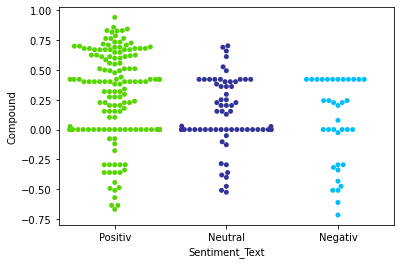

In [43]:
# trying to find thresholds in compound score to identify cutoffs between sentiments 
# there are no clear cutoffs. A positive sentiment has compound scores "all over the place". 
# A neutral sentiments looks like the mini version of the positive scores. See plot and table below.
sns.swarmplot(x='Sentiment_Text',y='Compound',data=df)

In [44]:
# compute compound scores thresholds for neutral
df.groupby('Sentiment_Text')['Compound'].describe().transpose() # for all rows with positive sentiment

Sentiment_Text,Negativ,Neutral,Positiv
count,36.000000,70.000000,160.000000
mean,0.055047,0.124340,0.273021
std,0.361313,0.284702,0.374586
min,-0.717800,-0.526700,-0.670500
25%,-0.296000,0.000000,0.000000
50%,0.139750,0.012900,0.318200
75%,0.421500,0.376650,0.612400
max,0.421500,0.703400,0.942300


In [45]:
print(confusion_matrix(df['Sentiment'],df['Comp_Sentiment']))
print(classification_report(df['Sentiment'],df['Comp_Sentiment']))

[[10  8 18]
 [ 8 33 29]
 [18 47 95]]
              precision    recall  f1-score   support

           0       0.28      0.28      0.28        36
           1       0.38      0.47      0.42        70
           2       0.67      0.59      0.63       160

    accuracy                           0.52       266
   macro avg       0.44      0.45      0.44       266
weighted avg       0.54      0.52      0.53       266



##### Predict 2 Sentiments

In [46]:
df['Comp_Sentiment_Easy'] = df['Compound'].apply(lambda c: 1 if c >=0.2 else 0)

In [47]:
print(confusion_matrix(df['Sentiment_Easy'],df['Comp_Sentiment_Easy']))
print(classification_report(df['Sentiment_Easy'],df['Comp_Sentiment_Easy']))

[[59 47]
 [65 95]]
              precision    recall  f1-score   support

           0       0.48      0.56      0.51       106
           1       0.67      0.59      0.63       160

    accuracy                           0.58       266
   macro avg       0.57      0.58      0.57       266
weighted avg       0.59      0.58      0.58       266



Results are no too positive. Predicting two sentiments is a bit better but still expandable. Unsupervised worse than baseline. With more time and data an own model can be trained as the Vader's data basis (social media text) does not deliver results. 

#### Strategie 3: Supervised Learning - use own NN

In [48]:
from numpy import asarray
from numpy import zeros
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

##### Predict three sentiments

In [174]:
X = df['Sentence_Cleaned']
y = df['Sentiment']
y = to_categorical(y)

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [176]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [177]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

# padding to achieve equal length
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [178]:
embeddings_dictionary = dict()
glove_file = open('data/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [179]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [180]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

In [181]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 100, 100)          96300     
_________________________________________________________________
flatten_8 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 30003     
Total params: 126,303
Trainable params: 30,003
Non-trainable params: 96,300
_________________________________________________________________
None


In [182]:
history = model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=0, validation_data=(X_test, y_test),  callbacks=[early_stop])  

Epoch 00060: early stopping


In [183]:
score = model.evaluate(X_test, y_test, verbose=1)

2/2 [==============================] - 0s 2ms/step - loss: 1.0729 - accuracy: 0.6296


In [184]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 1.0729115009307861
Test Accuracy: 0.6296296119689941


<AxesSubplot:>

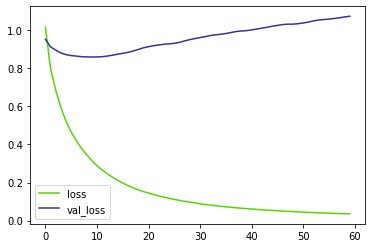

In [185]:
loss_df = pd.DataFrame(history.history)
loss_df[['loss', 'val_loss']].plot() 

##### Predict 2 sentiments

In [207]:
X = df['Sentence_Cleaned']
y = df['Sentiment_Easy']

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [209]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [210]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100

# padding to achieve equal length
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [211]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [212]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 100, 100)          96300     
_________________________________________________________________
flatten_11 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 10001     
Total params: 106,301
Trainable params: 10,001
Non-trainable params: 96,300
_________________________________________________________________
None


In [213]:
history = model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=0, validation_data=(X_test, y_test),  callbacks=[early_stop])  

Epoch 00059: early stopping


In [214]:
score = model.evaluate(X_test, y_test, verbose=1)

2/2 [==============================] - 0s 2ms/step - loss: 0.7599 - accuracy: 0.6481


In [215]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.7598945498466492
Test Accuracy: 0.6481481194496155


<AxesSubplot:>

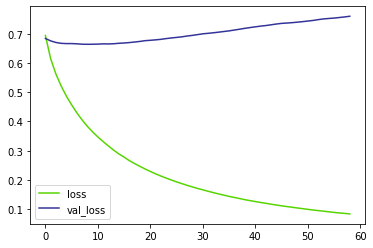

In [216]:
loss_df = pd.DataFrame(history.history)
loss_df[['loss', 'val_loss']].plot() 

### Tried a more complex network architecture namely LSTM

In [217]:
X = df['Sentence_Cleaned']
y = df['Sentiment']
y = to_categorical(y)

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [219]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [224]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

# padding to achieve equal length
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [225]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [226]:
print(model.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 100, 100)          96300     
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 387       
Total params: 213,935
Trainable params: 117,635
Non-trainable params: 96,300
_________________________________________________________________
None


In [227]:
history = model.fit(X_train, y_train, batch_size=128, epochs=60, verbose=0, 
                    validation_data=(X_test, y_test) )

In [228]:
score = model.evaluate(X_test, y_test, verbose=1)

2/2 [==============================] - 0s 9ms/step - loss: 1.0822 - acc: 0.5556


In [229]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


Test Score: 1.082205891609192
Test Accuracy: 0.5555555820465088


<AxesSubplot:>

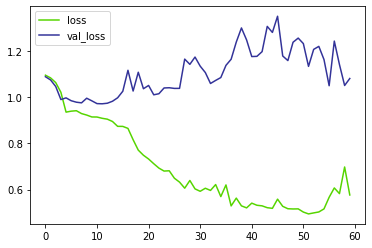

In [230]:
loss_df = pd.DataFrame(history.history)
# plot
loss_df[['loss', 'val_loss']].plot()